# Image classifier PyTorch

Scratchpad to teach building an image classifier in PyTorch. Materials are from various sources.

## Basic imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam 

In [2]:
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

## Setting device to use metal shader backend, if available

In [3]:
device = 'mps' if torch.mps.is_available() else 'cpu'
print(device)

mps


## Dataset MNIST

In [4]:
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True)
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True)

In [5]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train


In [6]:
print(test_set)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test


In [7]:
image, label = train_set[0]
image

In [8]:
type(image), type(label)

(PIL.Image.Image, int)

In [9]:
image_tensor = F.to_tensor(image)
type(image_tensor), image_tensor.shape

(torch.Tensor, torch.Size([1, 28, 28]))

In [10]:
trn = transforms.Compose([lambda img: F.to_tensor(img)])
img_tensor = trn(image)
type(img_tensor), torch.max(img_tensor), torch.min(image_tensor), image_tensor.shape

(torch.Tensor, tensor(1.), tensor(0.), torch.Size([1, 28, 28]))

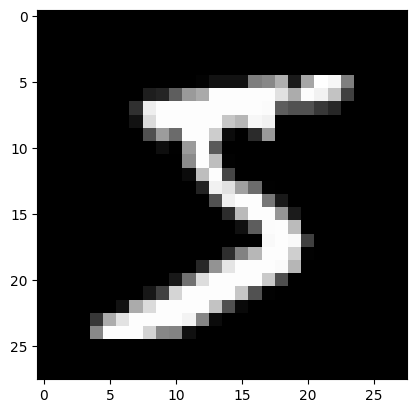

In [11]:
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.show()

In [12]:
train_set.transform = trn
test_set.transform = trn

In [13]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

## Build a model

In [14]:
tensor = torch.tensor([[[1, 2, 3], [4, 5, 6]]])
tensor.shape

torch.Size([1, 2, 3])

In [15]:
flatten = nn.Flatten()
flatten(tensor).shape

# Flatten(start_dim=1, end_dim=-1)
# (batch_size, channel, height, width) -> Flatten -> (batch_size, channel * height * width)


torch.Size([1, 6])

In [16]:
n_classes = 10
layers = [
    nn.Flatten(),
    nn.Linear(1*28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, n_classes)
]
print(layers)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=512, bias=True), ReLU(), Linear(in_features=512, out_features=512, bias=True), ReLU(), Linear(in_features=512, out_features=10, bias=True)]


In [17]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [18]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [19]:
#model = torch.compile(model)
#model

## Training and evaluating

In [20]:
loss_function = nn.CrossEntropyLoss() # applies softmax to the output and computes negative log likelihood

In [21]:
optimizer = Adam(model.parameters())

In [22]:
# list(model.parameters())

In [23]:
num_train = len(train_loader.dataset)
num_test = len(test_loader.dataset)
num_train, num_test

(60000, 10000)

In [24]:
def get_batch_accuracy(batch_output, y, num):
    pred = batch_output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / num

In [25]:
def train():
    loss, accuracy = 0, 0
    model.train() 
    for X, y in train_loader:
        optimizer.zero_grad()
        
        X, y = X.to(device), y.to(device)
        output = model(X)

        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, num_train)
    print(f'Train - Loss: {loss:4f} Accuracy: {accuracy:4f}')
        
        

In [26]:
def validate():
    loss, accuracy = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, num_test)
        print(f'Test - Loss: {loss:4f} Accuracy: {accuracy:4f}')

In [27]:
from tqdm import tqdm

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train()
    validate()

  0%|                                                                                                                 | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train - Loss: 377.079644 Accuracy: 0.938250


 20%|█████████████████████                                                                                    | 1/5 [00:13<00:52, 13.15s/it]

Test - Loss: 31.301063 Accuracy: 0.968200
Epoch: 1
Train - Loss: 158.412193 Accuracy: 0.974133


 40%|██████████████████████████████████████████                                                               | 2/5 [00:25<00:38, 12.92s/it]

Test - Loss: 28.961997 Accuracy: 0.972100
Epoch: 2
Train - Loss: 110.245609 Accuracy: 0.981100


 60%|███████████████████████████████████████████████████████████████                                          | 3/5 [00:38<00:25, 12.65s/it]

Test - Loss: 25.053026 Accuracy: 0.976700
Epoch: 3
Train - Loss: 83.818785 Accuracy: 0.985783


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 4/5 [00:49<00:12, 12.24s/it]

Test - Loss: 24.899587 Accuracy: 0.977800
Epoch: 4
Train - Loss: 64.039081 Accuracy: 0.989333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.29s/it]

Test - Loss: 27.231002 Accuracy: 0.978200


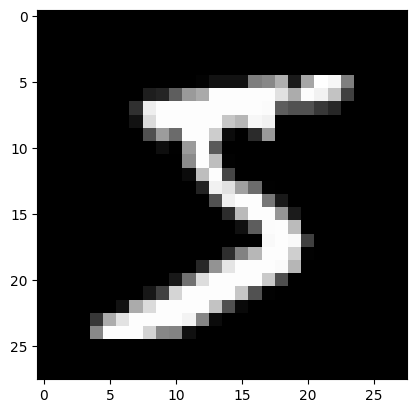

In [28]:
plt.imshow(img_tensor.squeeze(), cmap='gray')

In [32]:
with torch.no_grad():
    pred = model(img_tensor.to(device))
pred

tensor([[-25.3625,  -8.3976, -13.6444,  10.9982, -25.6502,  15.6218, -19.7209,
         -12.6001, -12.7577,  -8.3892]], device='mps:0')

In [33]:
pred.argmax(dim=1) # correctly identifies 5!

tensor([5], device='mps:0')

In [46]:
image, label = train_set[torch.randint(0, num_train, (1, 1)).item()]

1

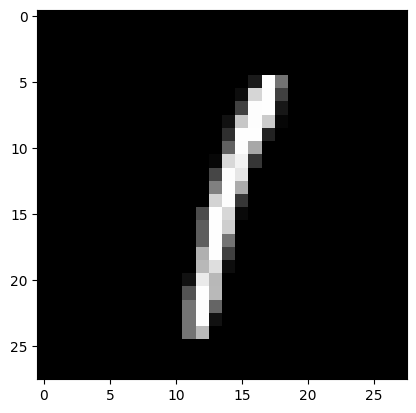

In [47]:
plt.imshow(image.squeeze(), cmap='gray')

In [50]:
with torch.no_grad():
    pred = model(image.to(device))
pred

tensor([[-13.5442,  15.0895,  -9.4664, -16.6339,  -0.3901, -14.5112,  -9.7415,
          -5.6486,  -7.1835,  -9.0378]], device='mps:0')

In [51]:
pred.argmax(dim=1) # correctly identifies 1!

tensor([1], device='mps:0')